## Harry Potter Books sentiment analysis
Now that we have scraped the Harry Potter books, let's do some sentiment analysis on them. We will use the NRC Word Emotion Lexicon and plot the distribution of emotions/sentiments across all books, and then finally on a corpus of all seven books.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from datetime import datetime as dt
import numpy as np
import os

### Read in NRC Word Emotion Lexicon
Let's read the lexicon into a dataframe, and then we can check to make sure that everything is filled out correctly

In [2]:
NRC_Path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
emolex_df = pd.read_csv(NRC_Path,  names=["word", "emotion", "association"], skiprows=1, sep='\t')
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index().rename_axis(None, axis=1)
emolex_words = emolex_words[emolex_words['word'].notnull()]
emolex_words.set_index('word', inplace=True)
emolex_words.head()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
word,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [3]:
for col in emolex_words:
    print('Null in {}? {}'.format(col, emolex_words[col].isnull().any()))

Null in anger? False
Null in anticipation? False
Null in disgust? False
Null in fear? False
Null in joy? False
Null in negative? False
Null in positive? False
Null in sadness? False
Null in surprise? False
Null in trust? False


#### Just Some Data Exploration
Find what the most common emotions are

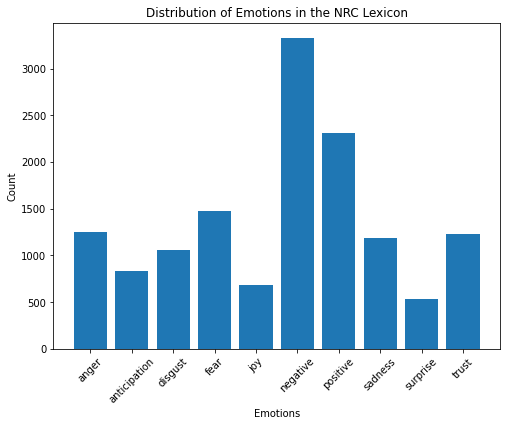

In [4]:
cols = emolex_words.columns
sums = [emolex_words[col].sum() for col in emolex_words]

plt.gcf().set_size_inches(8, 6)
plt.bar(cols, sums)
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.title('Distribution of Emotions in the NRC Lexicon')
plt.show()

### Loading the Data

In [5]:
books_df = pd.read_csv('harry_potter.csv',index_col=0)
books_df.head()

,title,text,shortened_title
0,Harry Potter and the Order of the Phoenix (Har...,The hottest day of the summer so far was draw...,Harry Potter #5
1,Harry Potter and the Chamber of Secrets (Harry...,"Not for the first time, an argument had broke...",Harry Potter #2
2,Harry Potter and the Deathly Hallows (Harry Po...,"The two men appeared out of nowhere, a few ya...",Harry Potter #7
3,Harry Potter and the Half-Blood Prince (Harry ...,It was nearing midnight and the Prime Ministe...,Harry Potter #6
4,Harry Potter and the Goblet of Fire (Harry Pot...,The villagers of Little Hangleton still calle...,Harry Potter #4


### Cleaning the Data
To make the data more useful for analysis, we can remove punctuation and convert to lowercase.

In [6]:
import string
books_df['processed_text'] = books_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
books_df['processed_text'] = books_df['processed_text'].apply(lambda x: x.lower())
books_df['processed_text'].head()

0     the hottest day of the summer so far was draw...
1     not for the first time an argument had broken...
2     the two men appeared out of nowhere a few yar...
3     it was nearing midnight and the prime ministe...
4     the villagers of little hangleton still calle...
Name: processed_text, dtype: object

#### Brief Exploration
Let's see what the most common words are and create a visualization. We can do this by using WordCloud

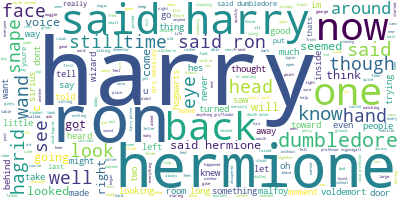

In [7]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(' '.join(books_df['processed_text'].values))
wordcloud.to_image()

### Graphing
Now let's graph how many times each emotion appears in the corpus

In [8]:
import nltk

t0 = dt.now()

# aggregate the emotions
emotions = pd.Series(data=[0]*len(emolex_words.columns), index=emolex_words.columns)
words = nltk.word_tokenize(' '.join(books_df['processed_text'].values))
for i in range(len(words)):
    try:
        emotions += emolex_words.loc[words[i]]
    except KeyError:
        pass

t1 = dt.now()
print('Time taken to aggregate: {}'.format(t1-t0))

Time taken to aggregate: 0:03:41.909595


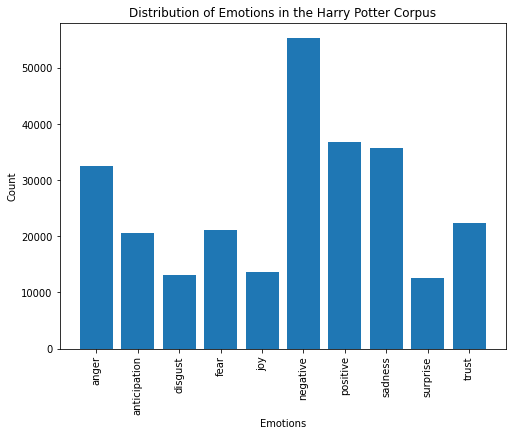

In [9]:
plt.figure()
plt.gcf().set_size_inches(8, 6)
plt.title('Distribution of Emotions in the Harry Potter Corpus')
plt.ylabel('Count')
plt.xlabel('Emotions')
x_pos = np.arange(len(emotions.keys()))
plt.bar(x_pos, emotions)
plt.xticks(x_pos, emotions.keys(), rotation=90)

plt.show()

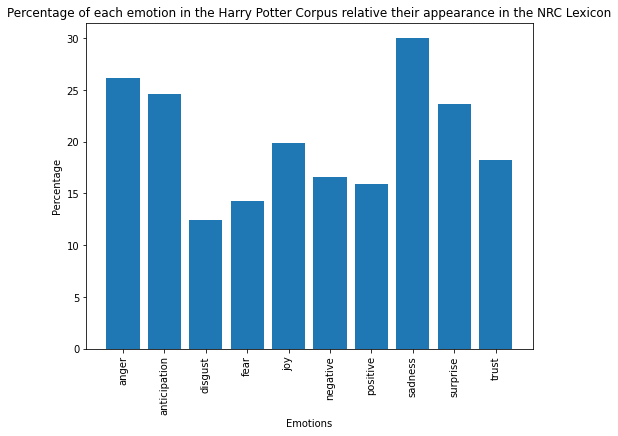

In [10]:
plt.figure()
plt.gcf().set_size_inches(8, 6)
plt.title('Percentage of each emotion in the Harry Potter Corpus relative their appearance in the NRC Lexicon')
plt.ylabel('Percentage')
plt.xlabel('Emotions')
x_pos = np.arange(len(emotions.keys()))
percentages = emotions / sums
plt.bar(x_pos, percentages)
plt.xticks(x_pos, emotions.keys(), rotation=90)

plt.show()

#### Analysis
It looks pretty obvious that according to the NRC Word-Emotion Lexicon, negative is by far the most prevalent emotion/sentiment conveyed in the Harry Potter books. Due to their nature of being fantasy novels with the protagonists often resisting some sort of evil, this is not a surprising result. However, in examining the graph it seemed as though the emotions in the Harry Potter corpus looked similar to the graph of the total sum of each emotion in the NRC Lexicon. To try to account for the fact that there are different amounts of each emotion in the NRC Lexicon, I divided the totals of each emotion in the Harry Potter corpus by the sum of each emotion's appearance in the NRC Lexicon. This gives us the second graph which shows the "amount" of each emotion in the HP corpus relative to the amount of each emotion in the NRC Lexicon. Reading the second graph, we see that anger, anticipation, sadness, surprise, and trust are far outrepresented in the HP corpus relative the NRC Lexicon. This is admittedly an imperfect way of analyzing this, but it gives interesting results nonetheless.